In [1]:
from google.colab import files
uploaded = files.upload()

Saving BTC-USD (2).csv to BTC-USD (2).csv


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import missingno as msno
from google.colab import data_table
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PowerTransformer
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics as metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from google.colab import data_table
import xgboost as xgb
from tqdm import tqdm
from sklearn.linear_model import SGDRegressor,PassiveAggressiveRegressor
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,Activation,Embedding,LSTM,Concatenate,Flatten,Dropout,Bidirectional
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam 
from tensorflow.keras import callbacks,Sequential
import tensorflow as tf
from datetime import datetime
import pytz
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras import backend as K
import shutil,os
import pickle

In [4]:
final_df = pd.read_csv('BTC-USD (2).csv').reset_index(drop=True)
final_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-10-08,336.115997,354.364014,327.187988,352.940002,352.940002,54736300
1,2014-10-09,352.747986,382.726013,347.687012,365.026001,365.026001,83641104
2,2014-10-10,364.687012,375.066986,352.963013,361.562012,361.562012,43665700
3,2014-10-11,361.362000,367.191010,355.950989,362.299011,362.299011,13345200
4,2014-10-12,362.605988,379.433014,356.144012,378.549011,378.549011,17552800
...,...,...,...,...,...,...,...
2918,2022-10-04,19623.583984,20380.343750,19523.839844,20336.843750,20336.843750,35887278685
2919,2022-10-05,20335.900391,20343.748047,19801.800781,20160.716797,20160.716797,33223790572
2920,2022-10-06,20161.039063,20408.392578,19900.087891,19955.443359,19955.443359,34711412966
2921,2022-10-07,19957.558594,20041.085938,19395.792969,19546.849609,19546.849609,29227315390


In [5]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(y, ypred):
    MAE = metrics.mean_absolute_error(y, ypred)
    RMSE = metrics.mean_squared_error(y, ypred,squared=False)
    return MAE,RMSE

def plot_results(y,ypred,title=None):
    plt.figure(figsize=(25,5))
    plt.plot(y,label='actual')
    plt.plot(ypred,label='predicted')
    plt.legend()
    plt.grid()
    plt.title(title)
    plt.show()

In [6]:
train_window = 500
test_window = 100
train_splits = []
test_splits = []
for i in tqdm(range(train_window, len(final_df),test_window)):
    train_split = final_df[i-train_window:i]
    test_split = final_df[i:i+test_window]
    train_splits.append(train_split)
    test_splits.append(test_split)

100%|██████████| 25/25 [00:00<00:00, 5845.56it/s]


In [7]:
def visualize_split(batch_no,show_plot=True):
    final_df.plot(x='Date',y='Close',figsize=(25,5))
    for i in range(train_splits[batch_no].index[0],train_splits[batch_no].index[-1]):
        plt.axvline(x=i,color='r',alpha=0.1)
    for i in range(test_splits[batch_no].index[0],test_splits[batch_no].index[-1]):
        plt.axvline(x=i,color='b',alpha=0.1)
    plt.grid()
    plt.legend('')
    plt.title(f'Temporal Window Split-{batch_no+1}')
    if not os.path.exists('/content/plot'):
        os.makedirs('/content/plot')
        
    plt.savefig(f'/content/plot/Temporal Window Split-{batch_no+1}.png')
    plt.show()

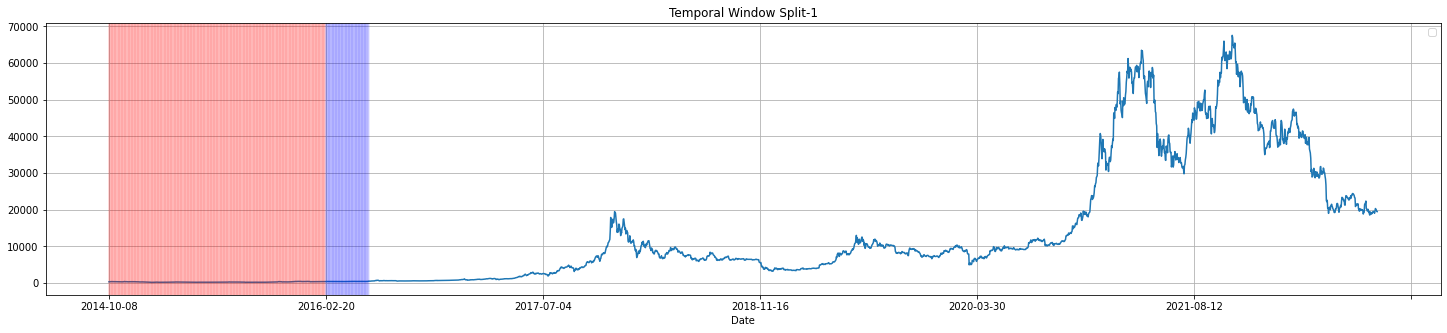

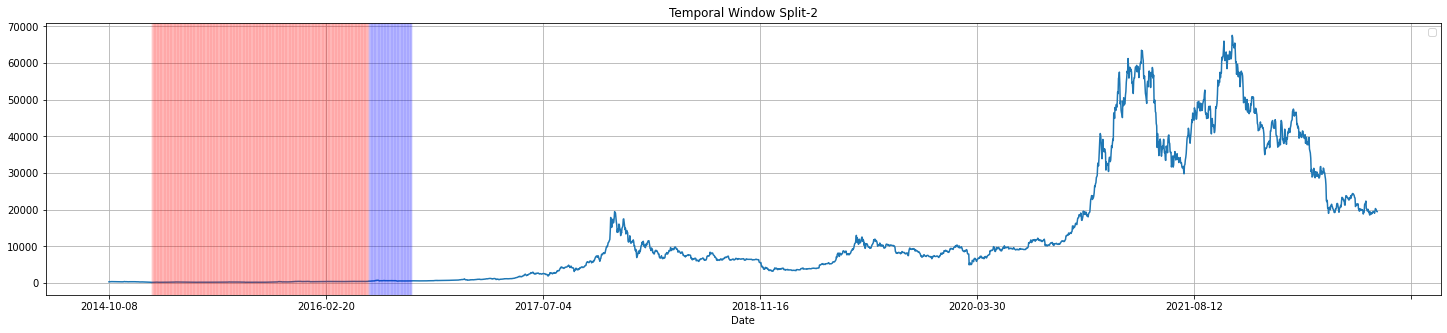

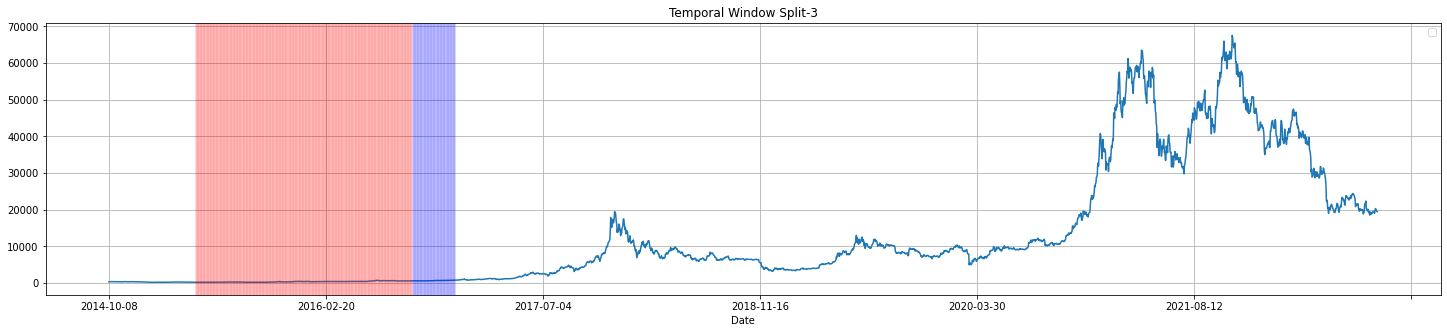

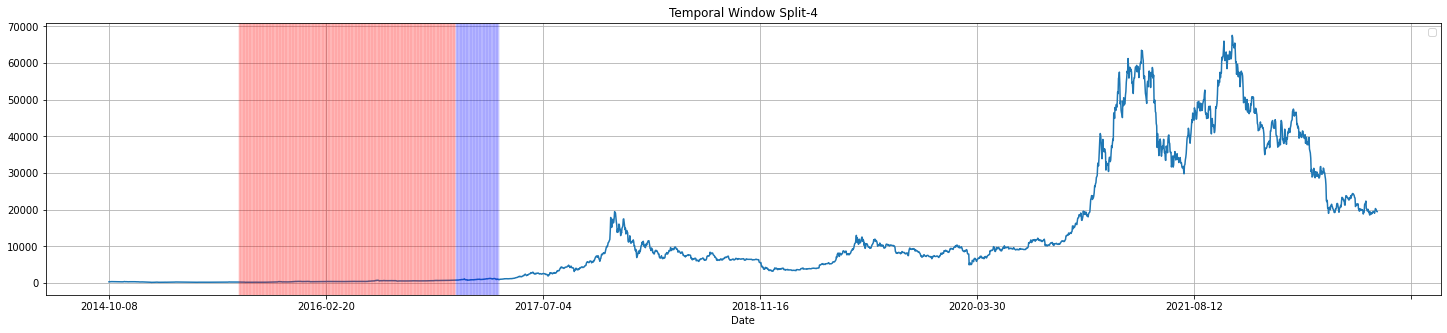

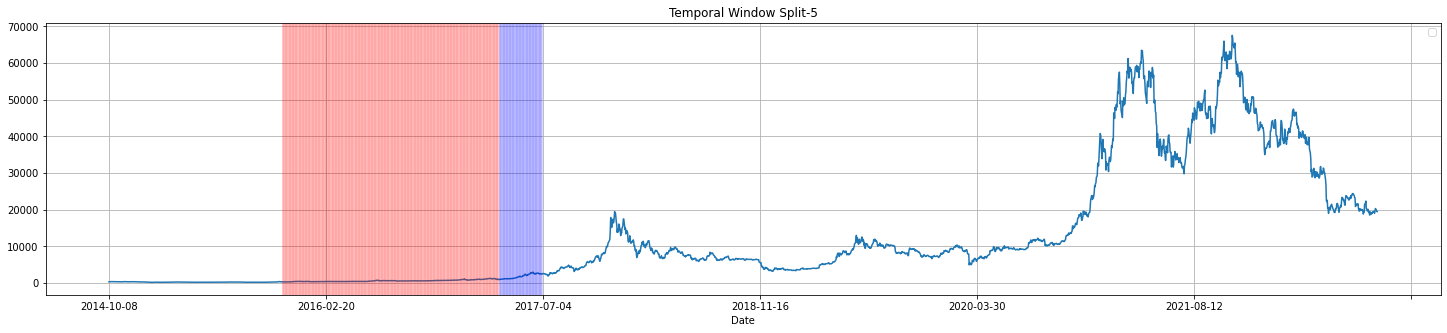

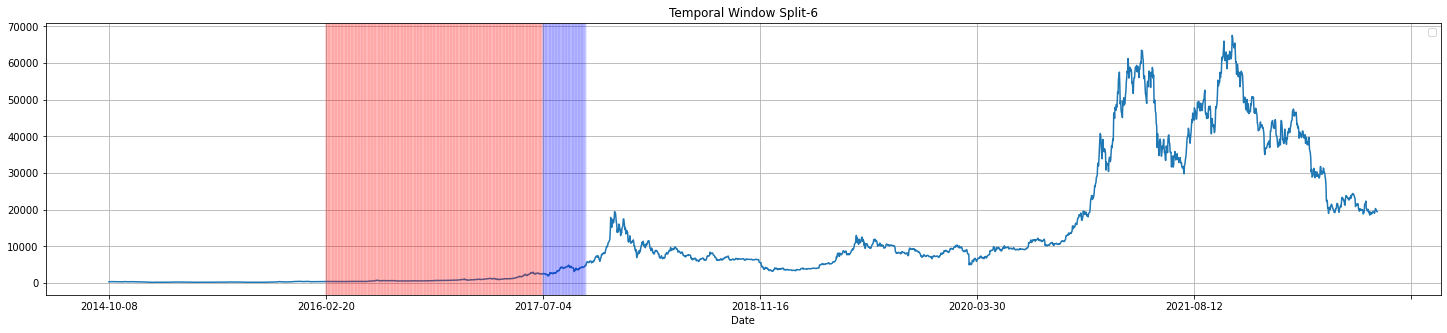

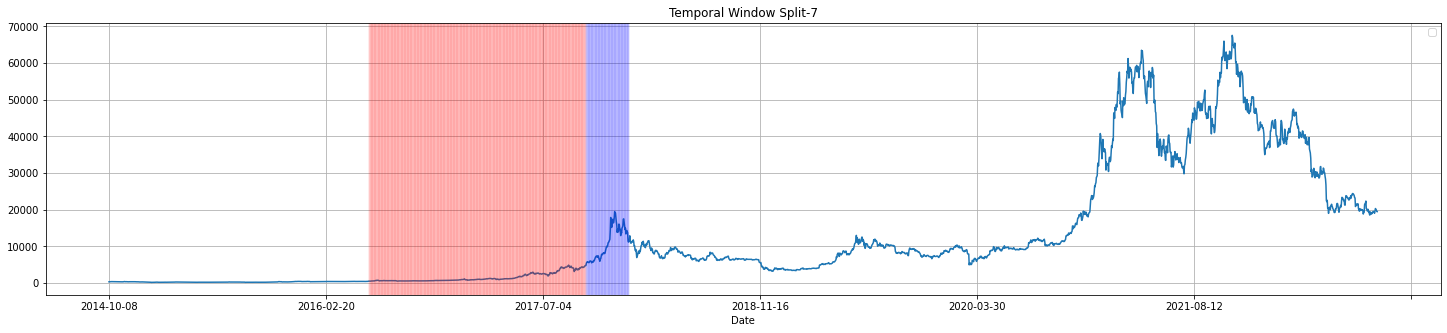

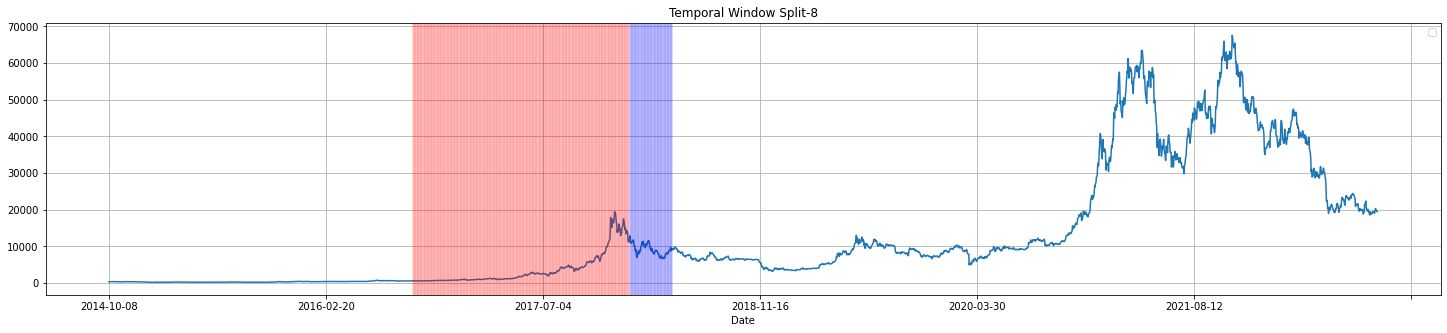

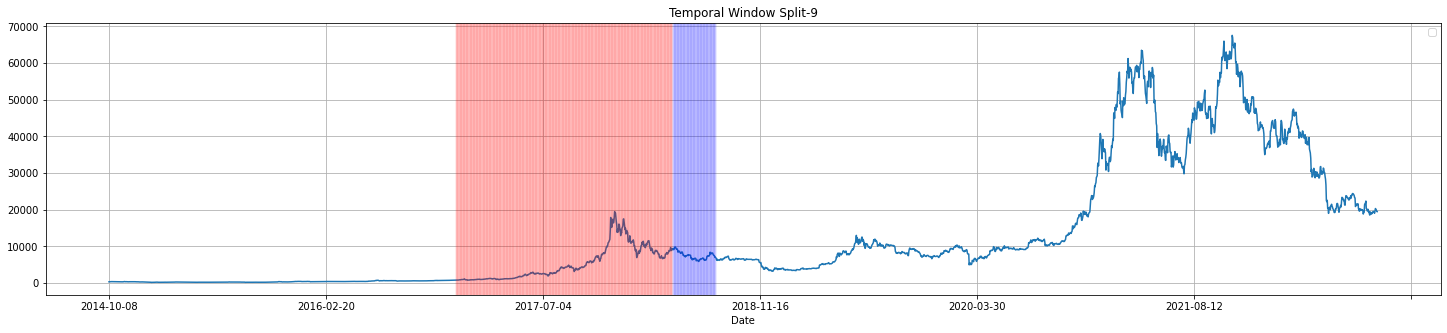

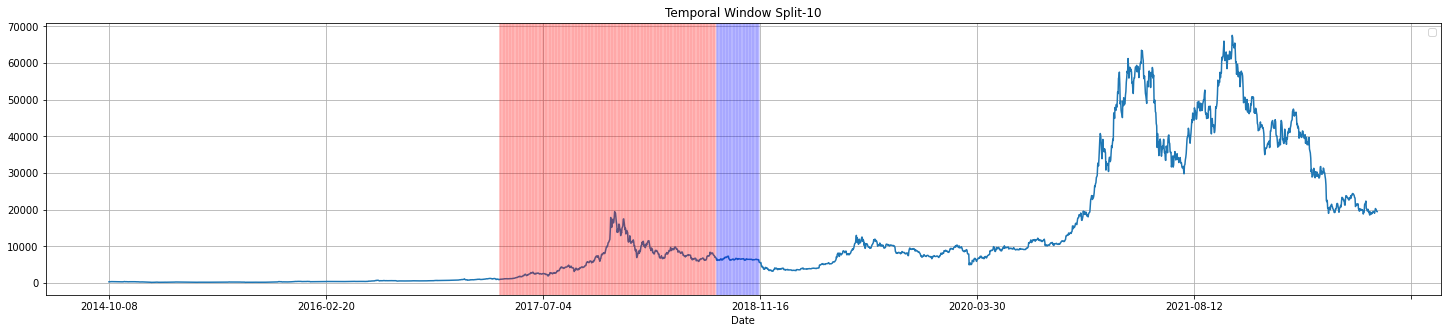

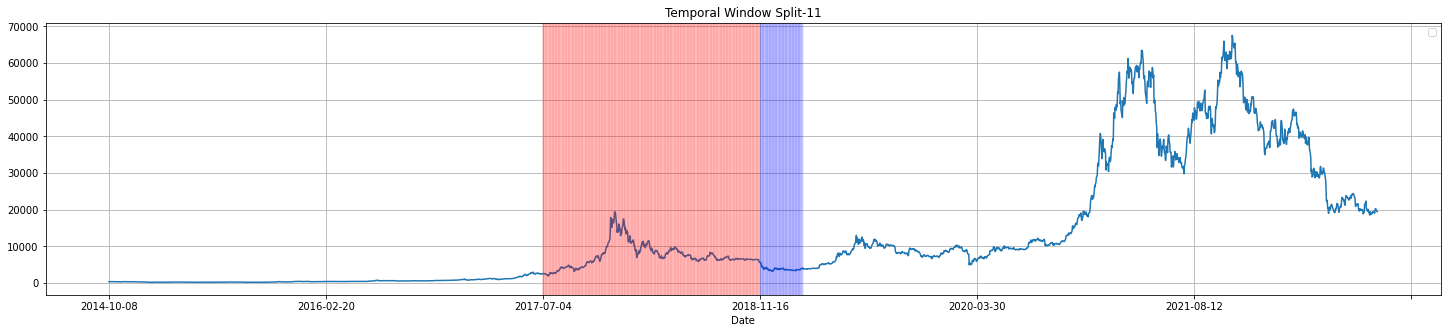

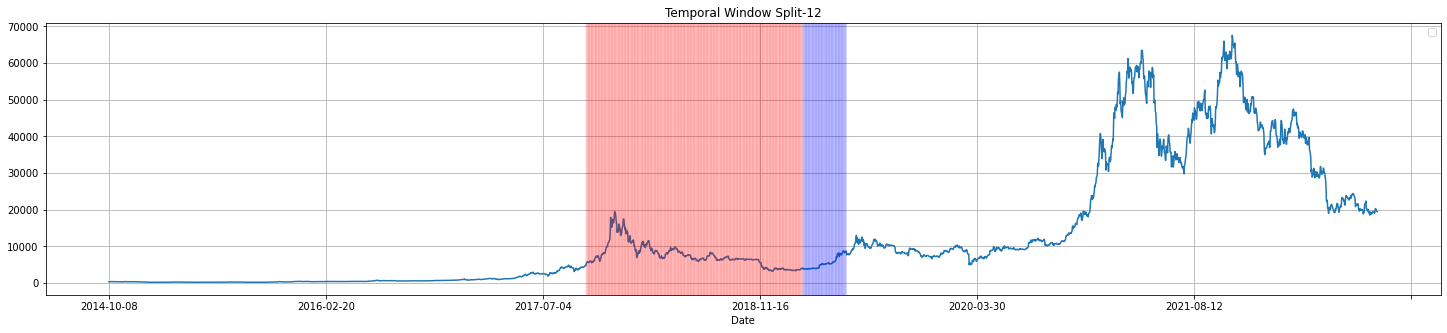

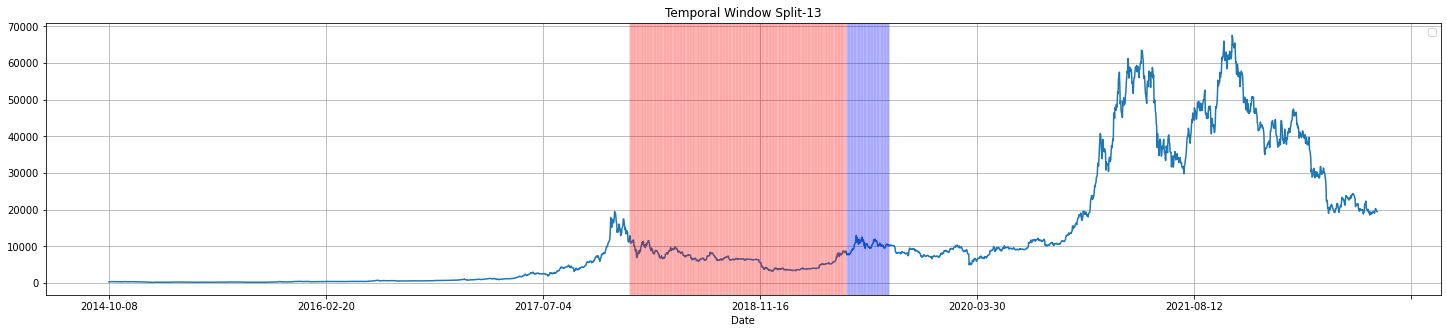

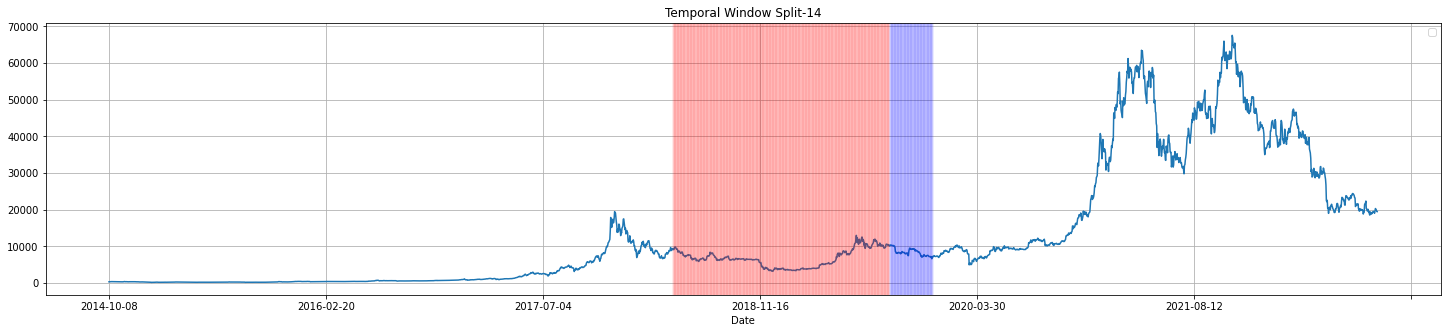

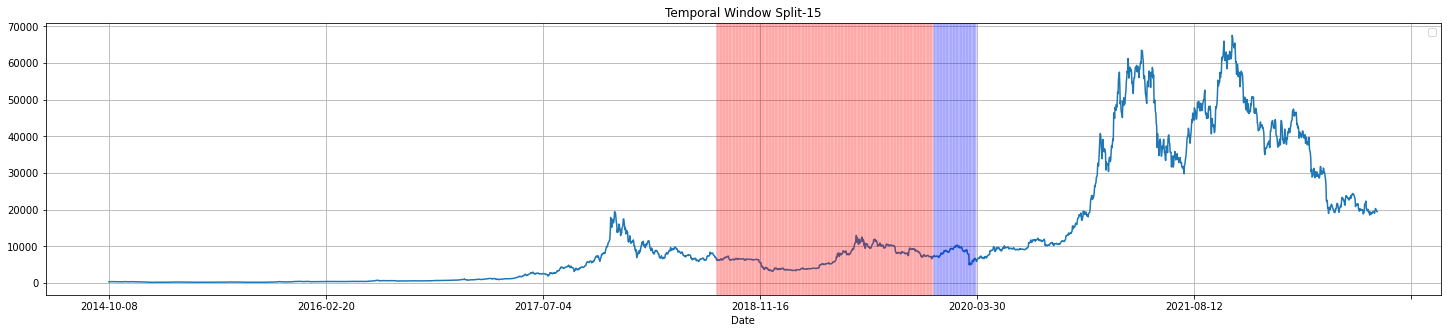

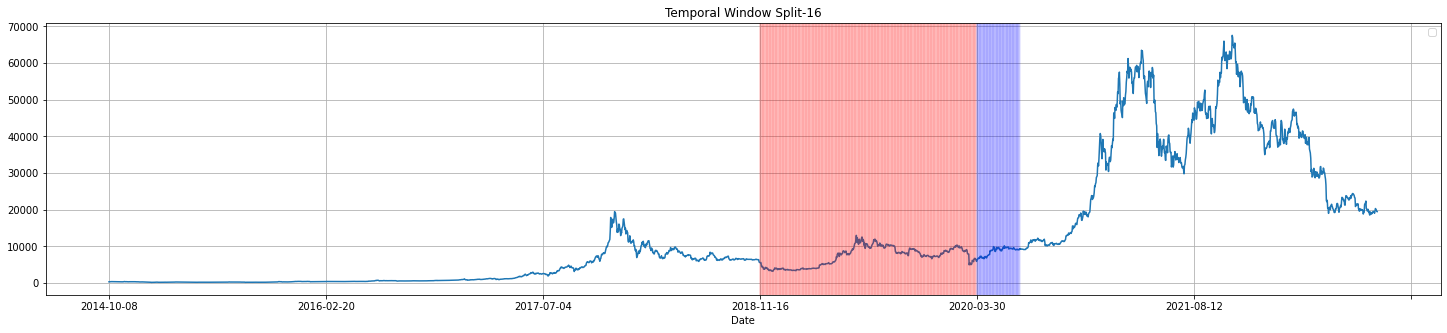

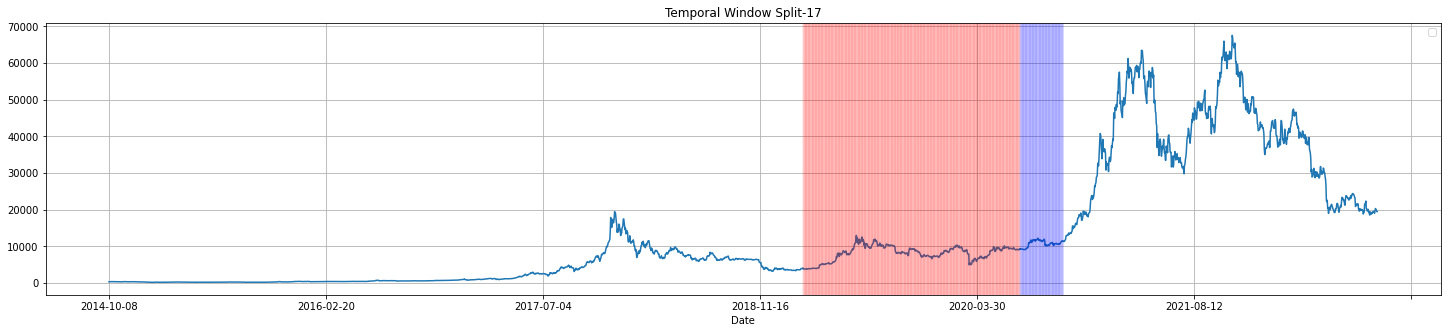

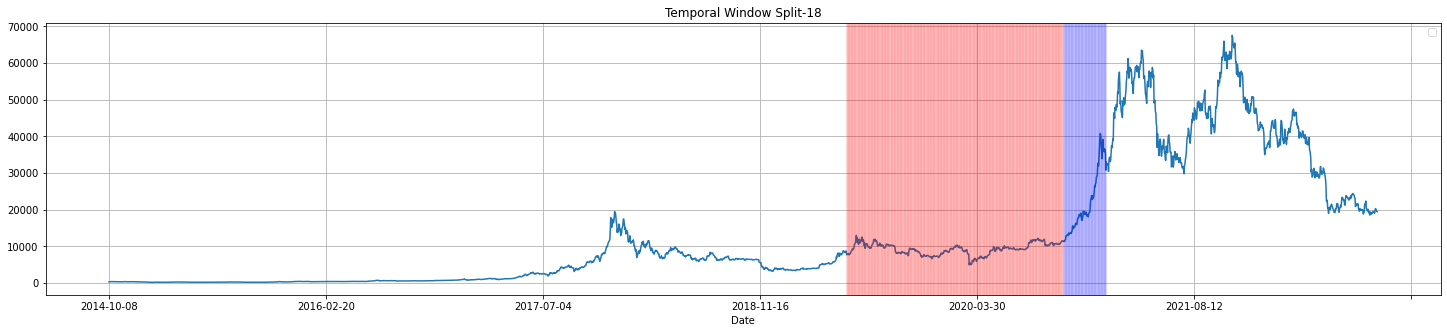

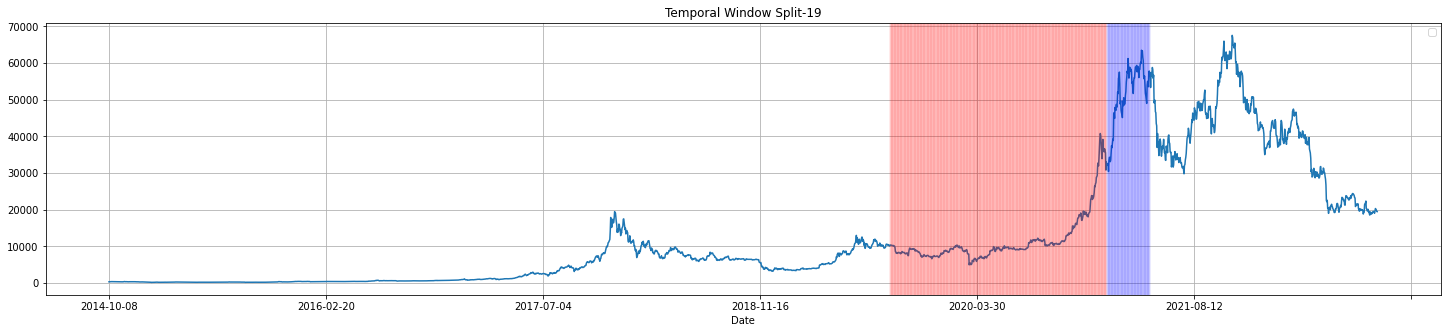

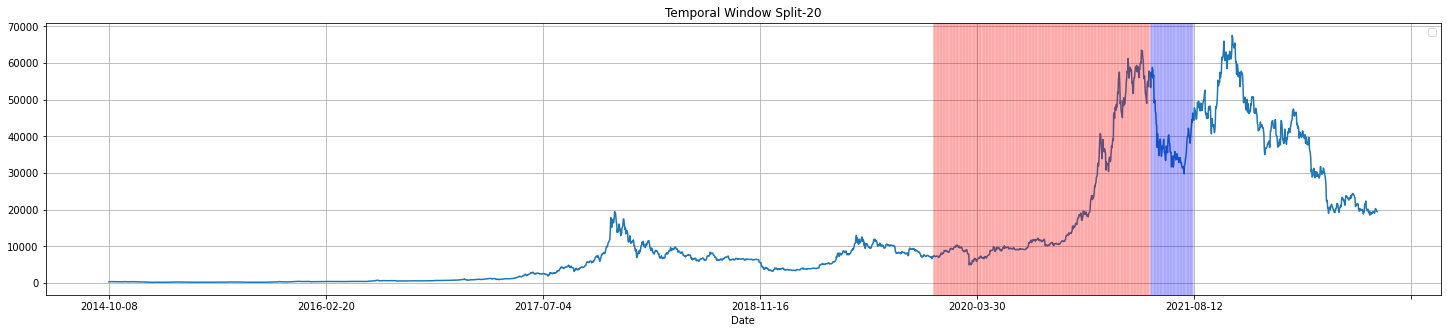

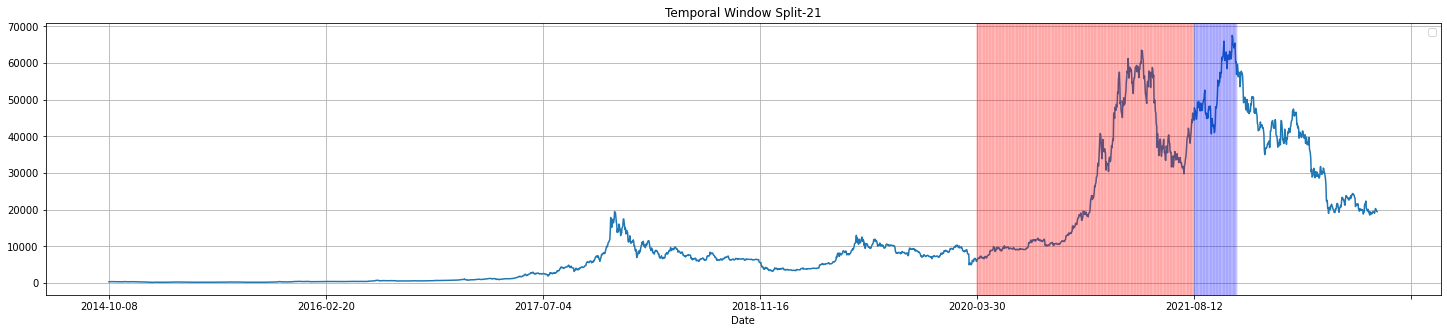

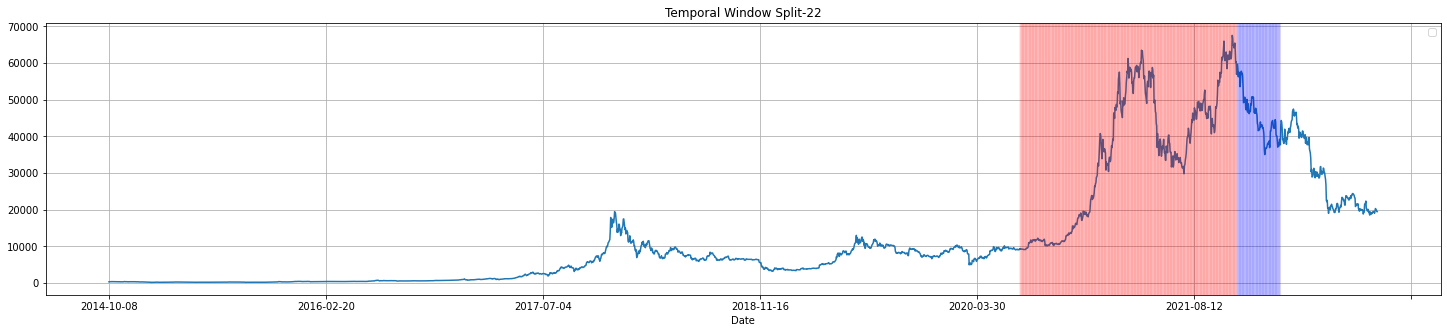

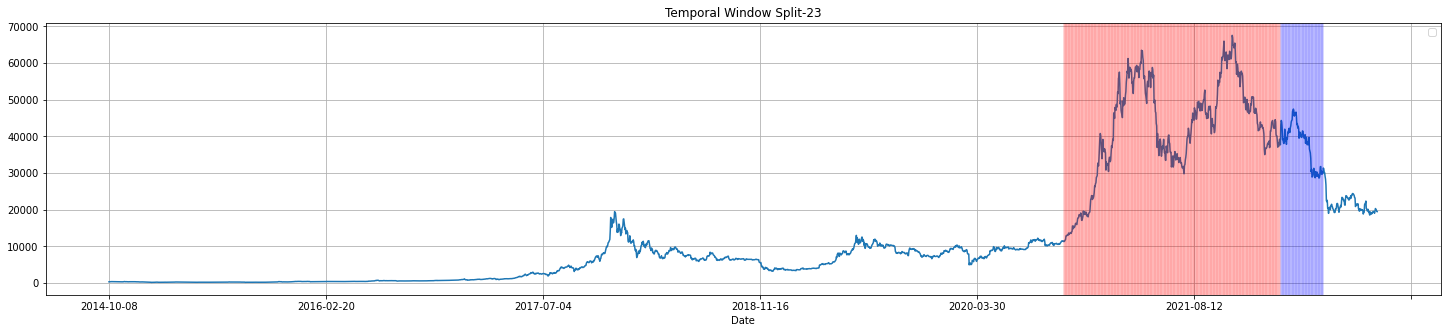

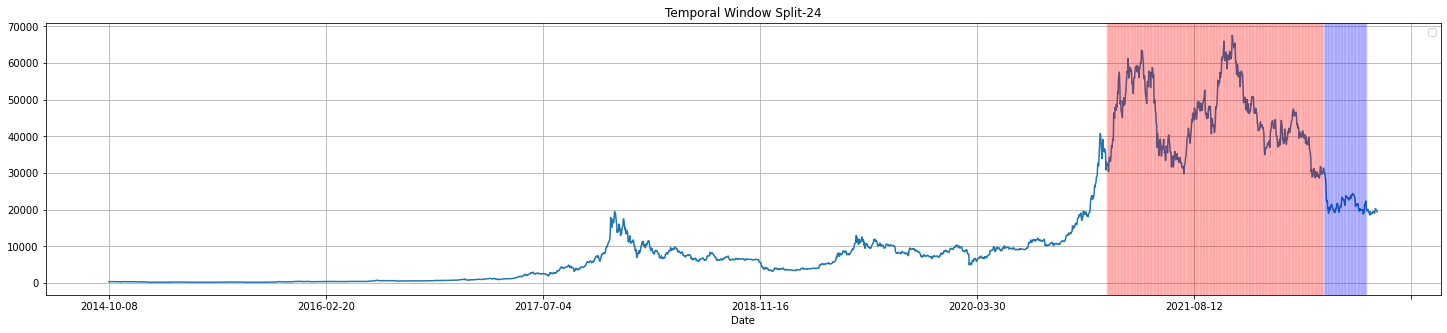

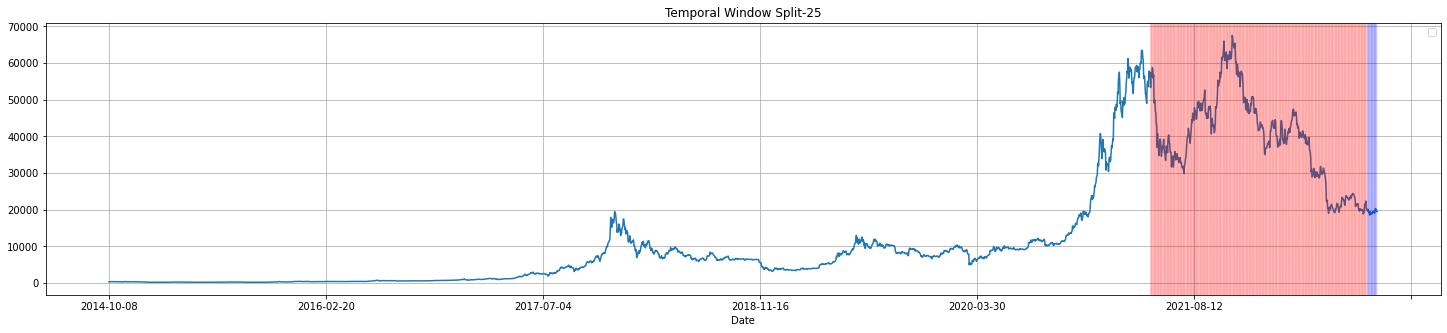

In [9]:
for i in range(len(train_splits)):
    visualize_split(i)

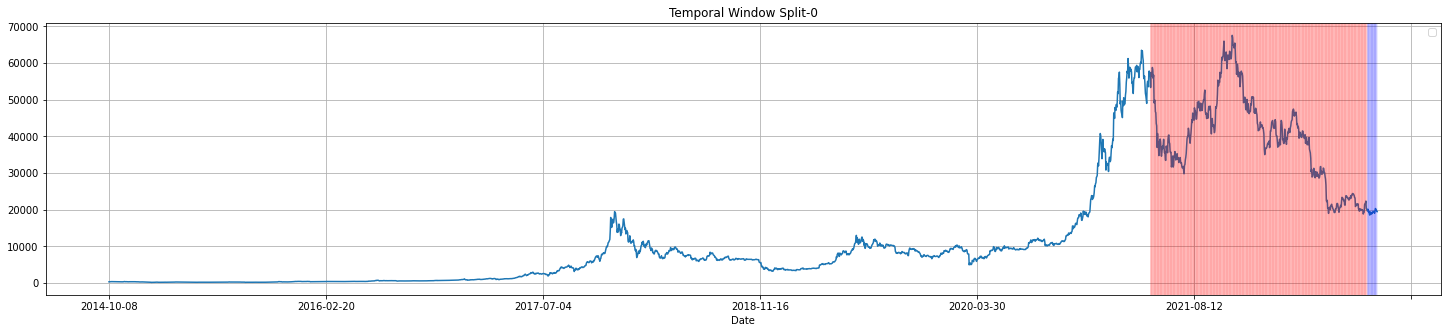

In [10]:
visualize_split(-1)

In [11]:
#dummy regressor
dmy_date_array = []
dmy_y_test_array = []
dmy_y_test_pred_array = []
dmy_batch_id_array = []
dmy_batch_id_array_result = []
dmy_batch_mae_train_array = []
dmy_batch_rmse_train_array = []
dmy_batch_mae_test_array = []
dmy_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['Close','Date'],axis=1).values
    Xtest_split = test_splits[i].drop(['Close','Date'],axis=1).values

    ytrain_split = train_splits[i]['Close'].reset_index(drop=True).values
    ytest_split = test_splits[i]['Close'].reset_index(drop=True).values

    dmy = DummyRegressor(strategy="quantile",quantile=0.9)
    dmy.fit(Xtrain_split, ytrain_split)

    ytrain_pred = dmy.predict(Xtrain_split)
    ytest_pred = dmy.predict(Xtest_split)

    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    dmy_date_array.extend(test_splits[i]['Date'])
    dmy_y_test_array.extend(test_splits[i]['Close'])
    dmy_y_test_pred_array.extend((ytest_pred.flatten()))
    dmy_batch_id_array.extend([i]*len(test_splits[i]))

    dmy_batch_id_array_result.append(i)
    dmy_batch_mae_train_array.append(MAE_train)
    dmy_batch_rmse_train_array.append(RMSE_train)

    dmy_batch_mae_test_array.append(MAE_test)
    dmy_batch_rmse_test_array.append(RMSE_test)

dmy_result_test_df = pd.DataFrame()
dmy_result_test_df['batch_id'] = dmy_batch_id_array
dmy_result_test_df['Date'] = dmy_date_array
dmy_result_test_df['y_test'] = dmy_y_test_array
dmy_result_test_df['y_test_pred'] = dmy_y_test_pred_array
dmy_y_test_array = dmy_result_test_df['y_test']
dmy_y_test_pred_array = dmy_result_test_df['y_test_pred']
dmy_result_metrics_df = pd.DataFrame()
dmy_result_metrics_df['batch_id'] = dmy_batch_id_array_result
dmy_result_metrics_df['mae_train'] = dmy_batch_mae_train_array
dmy_result_metrics_df['rmse_train'] = dmy_batch_rmse_train_array
dmy_result_metrics_df['mae_test'] = dmy_batch_mae_test_array
dmy_result_metrics_df['rmse_test'] = dmy_batch_rmse_test_array

100%|██████████| 25/25 [00:00<00:00, 328.33it/s]


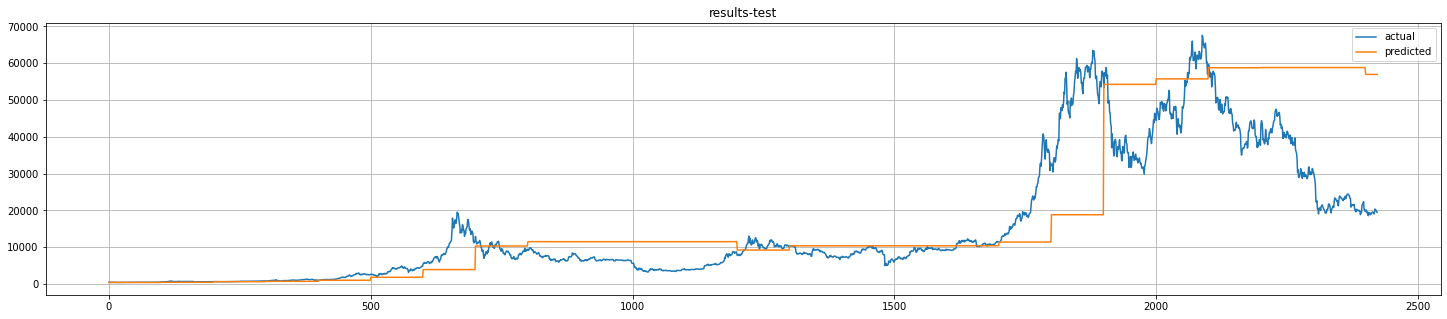

In [12]:
plot_results(dmy_y_test_array,dmy_y_test_pred_array,'results-test')

In [23]:
dmy_result_metrics_df

,batch_id,mae_train,rmse_train,mae_test,rmse_test
0,0,107.457681,123.053146,34.106453,40.144413
1,1,127.334693,152.016829,181.186844,188.862211
2,2,227.158595,257.158550,71.707930,94.321301
3,3,231.699700,274.862597,307.025655,334.554098
4,4,393.392617,435.310267,879.674751,1080.550096
5,5,1008.846357,1058.131756,1817.986463,1994.627022
6,6,2418.418368,2629.463655,7065.428198,8292.618290
7,7,7595.720798,7940.655350,1607.842330,1887.930443
8,8,6866.128738,7643.043082,4019.817583,4139.402746
9,9,5574.169627,6314.669265,4976.563672,4983.389815


In [24]:
pd.DataFrame(dmy_result_metrics_df.mean()).drop(['batch_id'],axis=0)

,0
mae_train,7988.212007
rmse_train,9186.565480
mae_test,8731.168390
rmse_test,9190.741437


In [25]:
dmy_result_test_df.to_csv('BTC-USD (2).csv')
dmy_result_metrics_df.to_csv('BTC-USD (2).csv')

In [26]:

#svr
svr_date_array = []
svr_y_test_array = []
svr_y_test_pred_array = []
svr_batch_id_array = []
svr_batch_id_array_result = []
svr_batch_mae_train_array = []
svr_batch_rmse_train_array = []
svr_batch_mae_test_array = []
svr_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['Close','Date'],axis=1).values
    Xtest_split = test_splits[i].drop(['Close','Date'],axis=1).values

    ytrain_split = train_splits[i]['Close'].reset_index(drop=True).values
    ytest_split = test_splits[i]['Close'].reset_index(drop=True).values

    svr = SVR(C=10000,gamma='auto',kernel='rbf')
    svr.fit(Xtrain_split, ytrain_split)

    ytrain_pred = svr.predict(Xtrain_split)
    ytest_pred = svr.predict(Xtest_split)

    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    svr_date_array.extend(test_splits[i]['Date'])
    svr_y_test_array.extend(test_splits[i]['Close'])
    svr_y_test_pred_array.extend((ytest_pred.flatten()))
    svr_batch_id_array.extend([i]*len(test_splits[i]))

    svr_batch_id_array_result.append(i)
    svr_batch_mae_train_array.append(MAE_train)
    svr_batch_rmse_train_array.append(RMSE_train)
    svr_batch_mae_test_array.append(MAE_test)
    svr_batch_rmse_test_array.append(RMSE_test)

svr_result_test_df = pd.DataFrame()
svr_result_test_df['batch_id'] = svr_batch_id_array
svr_result_test_df['Date'] = svr_date_array
svr_result_test_df['y_test'] = svr_y_test_array
svr_result_test_df['y_test_pred'] = svr_y_test_pred_array
svr_y_test_array = svr_result_test_df['y_test']
svr_y_test_pred_array = svr_result_test_df['y_test_pred']
svr_result_metrics_df = pd.DataFrame()
svr_result_metrics_df['batch_id'] = svr_batch_id_array_result
svr_result_metrics_df['mae_train'] = svr_batch_mae_train_array
svr_result_metrics_df['rmse_train'] = svr_batch_rmse_train_array
svr_result_metrics_df['mae_test'] = svr_batch_mae_test_array
svr_result_metrics_df['rmse_test'] = svr_batch_rmse_test_array

100%|██████████| 25/25 [00:01<00:00, 22.98it/s]


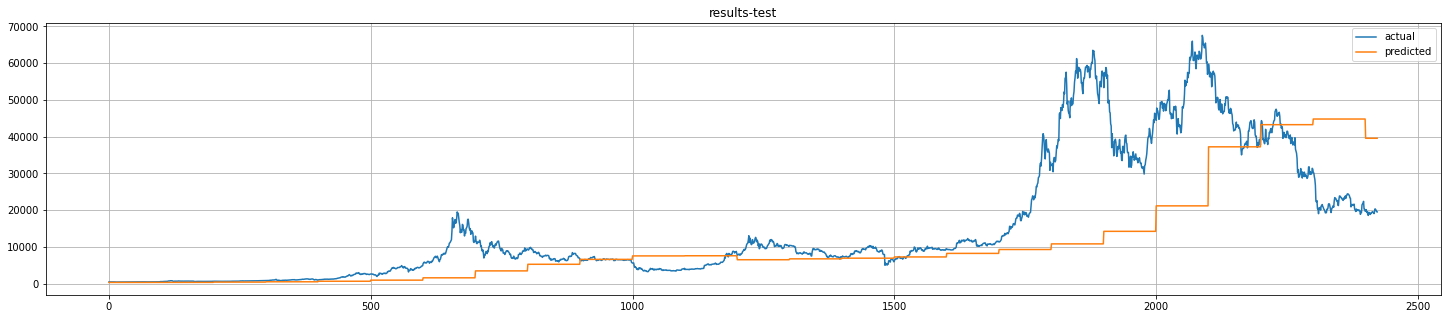

In [27]:
plot_results(svr_y_test_array,svr_y_test_pred_array,'results-test')

In [28]:
 svr_result_metrics_df

,batch_id,mae_train,rmse_train,mae_test,rmse_test
0,0,0.099981,0.099982,135.144032,136.795208
1,1,0.100010,0.100010,305.742649,310.352751
2,2,0.099987,0.099987,285.308488,292.127770
3,3,0.099996,0.099997,530.651963,547.040398
4,4,0.099980,0.099980,1248.299814,1397.543484
5,5,0.099982,0.099983,2698.072067,2820.116143
6,6,0.099998,0.099998,9396.287822,10350.723033
7,7,182.742463,794.353350,5674.557108,5861.595560
8,8,74.087805,436.299323,2225.558219,2434.919111
9,9,29.454373,238.124862,197.225328,269.405312


In [29]:
pd.DataFrame(svr_result_metrics_df.mean()).drop(['batch_id'])

,0
mae_train,1163.586468
rmse_train,2171.857820
mae_test,8297.390695
rmse_test,8782.841304


In [30]:
svr_result_test_df.to_csv('BTC-USD (2).csv')
svr_result_metrics_df.to_csv('BTC-USD (2).csv')